In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from utils import reset_seed, display_compare

import os

# tf.config.experimental.get_visible_devices()

In [2]:
from sklearn.model_selection import train_test_split
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train_full = np.float32(x_train_full/255.)
x_test       = np.float32(x_test/255.)
x_train, x_val,  y_train, y_val  = train_test_split(x_train_full, y_train_full, random_state=0)
print(x_train.shape)

(45000, 28, 28)


## VAEs
Let's implement a VAE by subclassing the Model class

In [3]:
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Lambda, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.nn import leaky_relu

def sampling_fn(inputs):
    mean, log_var = inputs
    eps = tf.random.normal(shape=tf.shape(mean))
    return eps * tf.exp(log_var / 2) + mean

class VEncoder(Layer):
    """Variational Encoder"""
    def __init__(self, latent_dim):
        super().__init__()
        self.flatten  = Flatten()
        self.hidden1  = Dense(150, activation=leaky_relu)
        self.hidden2  = Dense(100, activation=leaky_relu)
        self.lin_mean = Dense(latent_dim)
        self.lin_var  = Dense(latent_dim)
        self.sampling = Lambda(sampling_fn, name="sampling_layer")
    
    def call(self, x):
        z  = self.flatten(x)
        z  = self.hidden1(z)
        z  = self.hidden2(z)
        mean    = self.lin_mean(z)
        log_var = self.lin_var(z)
        codings = self.sampling([mean, log_var])
        return codings, mean, log_var
        
class VDecoder(Layer):
    """Variational Decoder"""
    def __init__(self):
        super().__init__()
        self.hidden1 = Dense(100, activation=leaky_relu)
        self.hidden2 = Dense(150, activation=leaky_relu)
        self.hidden3 = Dense(28 * 28, activation="sigmoid")
        self.reshape = Reshape([28, 28])
    
    def call(self, z):
        z  = self.hidden1(z)
        z  = self.hidden2(z)
        z  = self.hidden3(z)
        reconstruction = self.reshape(z)
        return reconstruction
    
class VAE(Model):
    """Variational autoencoder."""
    def __init__(self, latent_dim, kl_factor=0.0015):
        super().__init__()
        self.latent_dim = latent_dim
        self.kl_factor  = kl_factor
        self.encoder = VEncoder(latent_dim)
        self.decoder = VDecoder()
        
    def call(self, x):
        # Encoder
        z, mean, log_var = self.encoder(x)
        # Decoder
        reconstruction   = self.decoder(z)
        
        # Add KL Loss
        kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.exp(log_var) - tf.square(mean), axis=-1)
        self.add_loss(self.kl_factor * tf.reduce_mean(kl_loss))
        return reconstruction

In [4]:
reset_seed()
vae = VAE(2)
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")
vae.fit(x_train, x_train, epochs=25, batch_size=128, validation_data=(x_val, x_val))

Epoch 1/25
352/352 [==============================] - 1s 4ms/step - loss: 0.4052 - val_loss: 0.3668
Epoch 2/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3634 - val_loss: 0.3634
Epoch 3/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3570 - val_loss: 0.3539
Epoch 4/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3532 - val_loss: 0.3521
Epoch 5/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3505 - val_loss: 0.3541
Epoch 6/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3483 - val_loss: 0.3483
Epoch 7/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3466 - val_loss: 0.3461
Epoch 8/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3452 - val_loss: 0.3453
Epoch 9/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3439 - val_loss: 0.3450
Epoch 10/25
352/352 [==============================] - 1s 3ms/step - loss: 0.3429 - val_loss: 0.3435

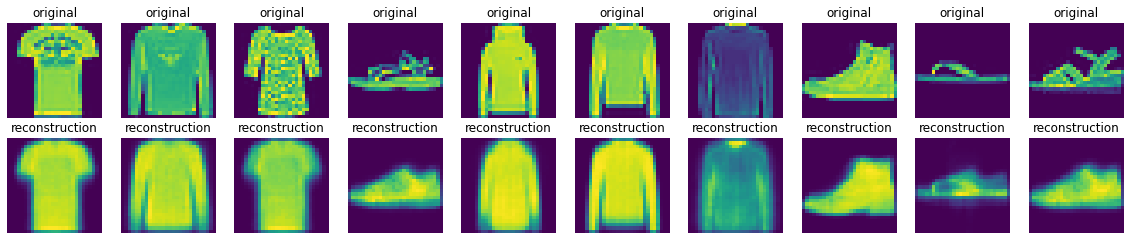

In [5]:
rec_vae = vae.predict(x_val)

display_compare(x_val, rec_vae, names=["original", "reconstruction"])

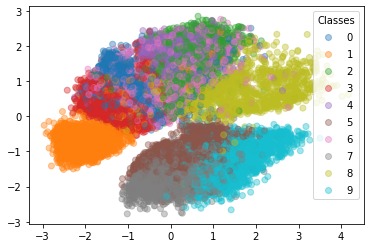

In [6]:
codings, *_ = vae.encoder(x_val)
scatter = plt.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.4)
legend1 = plt.legend(*scatter.legend_elements(), loc="best", title="Classes")

In [8]:
def get_curve(n_points=50, x_scale=1.5, y_scale=4):
    t_ = np.linspace(0,2*np.pi,n_points)
    curve_x = x_scale * np.sin(t_)
    curve_y = y_scale * np.sin(t_) * np.cos(t_)
    curve = np.vstack([curve_x, curve_y]).transpose()
    return np.float32(curve)

curve     = get_curve()
decoder   = vae.layers[1]
curve_rec = decoder(curve)

Done in 43.32s


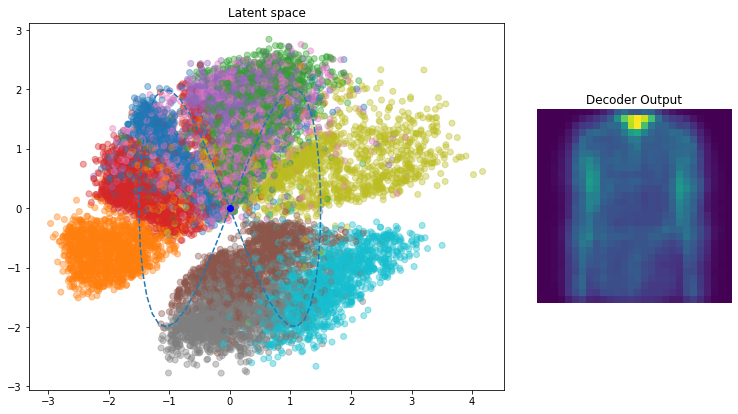

In [9]:
from time import time
from matplotlib.animation import FuncAnimation

start =time()
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.05, 0.05, .55, 0.85])
ax2 = fig.add_axes([.6, 0.25, 0.3, 0.45])
ax2.axis('off')
ax.set_title('Latent space')
title = ax2.set_title('Decoder Output')
ax.plot(*np.hsplit(curve,2), ls='--')

ax.scatter(*np.hsplit(codings,2), c=y_val, cmap="tab10", alpha=0.4)
point, = ax.plot(*curve[0], 'bo')
img = ax2.imshow(curve_rec[0])

def update(i):
    point.set_data(*curve[i])
    img = ax2.imshow(curve_rec[i])
    return point, img

anim = FuncAnimation(fig, update, frames=np.arange(len(curve)), interval=200)
anim.save('VAE.gif', writer='imagemagick')
print("Done in %.2fs"%(time()-start))